 Copyright (c) 2015-2020, Swiss Federal Institute of Technology (ETH Zurich)

 All rights reserved.
 
 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:
 
 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.
 
 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.
 
 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.
 
 THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
 AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
 IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
 DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
 FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
 DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
 SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
 CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
 OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
 OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set the notebook parameters, the path to the key file and change working-directory to the root directory of the dataprocessing framework.

In [2]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


Import all necessary packages.

In [3]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# Toolkit packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

# Plotting
from exot.plotting.experiment_plotter import *
from exot.plotting.run_plotter        import *

Tensorflow not available - excluding packets using it!


Parameters

# Generate Experiment
1. Load config

In [4]:
config = TOML.load(f"configurations/examples/demo_frequency_sweep_experiment.toml")
print(TOML.dumps(config))

name = "demo_frequency_sweep_experiment"
save_path = "./data"
backup_path = "./data/_backup"
experiment_exists_action = "update"

[EXPERIMENT]
type = "FrequencySweepExperiment"
channel = "ThermalCC"

[EXPERIMENT.GENERAL]
latency = 10
fan = true
governors = "userspace"
frequencies = "max"
sampling_period = 0.001
delay_after_spawn = 120.0
delay_after_auxiliary = 1.0
active_wait = false

[EXPERIMENT.PHASES.sweep]
length_seconds = 10
repetitions = 1
frequencies = [ 0, 1, 5, 10,]
signal = [ -1, 0,]

[EXPERIMENT.LAYERS.rdp]
name = "CoreActivation"

[EXPERIMENT.LAYERS.io]
name = "TimeValue"

[EXPERIMENT.GENERAL.ARMv7]
delay_after_spawn = 120.0
sampling_period = 0.005

[EXPERIMENT.GENERAL.ARMv8]
delay_after_spawn = 120.0
sampling_period = 0.005

[EXPERIMENT.LAYERS.rdp.params]

[EXPERIMENT.LAYERS.io.params]
timebase = "ns"

[ENVIRONMENTS.Haswell.APPS.snk]
executable = "meter_thermal_msr"
zone = "host"

[ENVIRONMENTS.Haswell.APPS.src]
executable = "generator_utilisation_mt"
zone = "host"

[ENVIR

2. Instantiate, generate and write the experiment

_Experiment factory will take the type and channel from the config._

In [5]:
channel = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)

experiment.generate()
experiment.print_duration()
experiment.config.experiment_exists_action = "update"
experiment.write()

2020-05-22 12:27:56 :: bootstrapped layer 'rdp' with CoreActivation
2020-05-22 12:27:56 :: bootstrapped layer 'io' with TimeValue
2020-05-22 12:27:57 :: Estimated duration of a single repetition of the sweep phase is 0:08:44
2020-05-22 12:27:57 :: This results in a total estimated duration of 0:08:44 for all repetitions.


## Execute

Running `execute` will execute in all environments present in the configuration.

In [6]:
experiment.config.experiment_exists_action = "update"

for env in ['ARMv8', 'Haswell']:
    experiment.execute_in_environment(env, ['sweep'], resume=True)

experiment.write()

2020-05-22 12:28:00 :: executing phases: ['sweep'] in env 'ARMv8'
2020-05-22 12:28:03 :: ARMv8->combined: connected: SSHUnixDriver
2020-05-22 12:28:03 :: ARMv8->combined: sending experiment
2020-05-22 12:28:04 :: ARMv8->combined: experiment sent!
2020-05-22 12:28:04 :: ARMv8->combined: configuring to {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'sampling_period': 0.005, 'delay_after_spawn': 120.0, 'delay_after_auxiliary': 1.0, 'active_wait': False, 'ARMv7': {'delay_after_spawn': 120.0, 'sampling_period': 0.005}, 'STANDARD': {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'sampling_period': 0.001, 'delay_after_spawn': 120.0, 'delay_after_auxiliary': 1.0, 'active_wait': False}}
2020-05-22 12:28:13 :: executing in env: 'ARMv8', resume: True, reps: [0], run: <Run at 0x7fe29c501c50 (digested, config={'phase': 'sweep', 'length_seconds': 10, 'frequency': 10, 'frequency_id': 3, 'repetitions': 1})>
2020-05-22 12:28:13 :: executing in 

## Analyse

Deserialisation. If diff_and_replace is true, ExOT will read the TOML configuration file in the experiment directory and check for differences with the pickled experiment object. If differences appear, they will be overwritten in the object. This allows users to update experiments after they have been generated, by modifying the experiment configuration TOML files in the experiment directory.

In [7]:
path_to_serialised_experiment = PATH.Path("data/demo_frequency_sweep_experiment/_experiment.pickle")
experiment = FrequencySweepExperiment.read(path_to_serialised_experiment, diff_and_replace=True)

2020-05-22 12:33:22 :: unpicked an experiment instance <FrequencySweepExperiment at 0x7fe298241d68 with ThermalCC channel, configured>
2020-05-22 12:33:22 :: configs from pickle and directory differ at [{'path': ('save_path',), 'left': 'data', 'right': './data'}]
2020-05-22 12:33:24 :: environments from pickle and directory differ at [{'path': ('Z5', 'bigLITTLE', 'beta_z', 'thermal_sysfs:zone:29:°C'), 'left': nan, 'right': nan}, {'path': ('Z5', 'bigLITTLE', 'beta_z', 'thermal_sysfs:zone:27:°C'), 'left': nan, 'right': nan}, {'path': ('Z5', 'bigLITTLE', 'beta_z', 'thermal_sysfs:zone:21:°C'), 'left': nan, 'right': nan}, {'path': ('Z5', 'bigLITTLE', 'beta_z', 'thermal_sysfs:zone:16:°C'), 'left': 0.014944333988331358, 'right': 0.01494433398833136}, {'path': ('Z5', 'bigLITTLE', 'beta_z_cool', 'thermal_sysfs:zone:35:°C'), 'left': 0.0025165760394085797, 'right': 0.00251657603940858}, {'path': ('Z5', 'bigLITTLE', 'beta_z', 'thermal_sysfs:zone:26:°C'), 'left': nan, 'right': nan}, {'path': ('Z5',

If `experiment.spectra` are not *None* or empty, that means that the analysis has already been performed and the spectra generation step can be skipped. See the output below:

In [8]:
empty = experiment.spectra is None or getattr(experiment, "spectra", pd.DataFrame()).empty
print("Empty?", empty)

Empty? True


Generate and plot the channel spectra of the two environments Haswell and ARMv8.

2020-05-22 12:33:25 :: \_ generating spectra for env: Haswell
2020-05-22 12:33:30 :: \_ generating spectra for env: Haswell
2020-05-22 12:33:35 :: \_ generating spectra for env: Haswell
2020-05-22 12:33:41 :: \_ generating spectra for env: Haswell
2020-05-22 12:33:45 :: \_ generating spectra for env: ARMv8
2020-05-22 12:33:50 :: \_ generating spectra for env: ARMv8
2020-05-22 12:33:55 :: \_ generating spectra for env: ARMv8
2020-05-22 12:34:01 :: \_ generating spectra for env: ARMv8
2020-05-22 12:34:06 :: \_ generating spectra for env: ARMv8
2020-05-22 12:34:13 :: \_ generating spectra for env: ARMv8


,host,core,C_wf,C_cwf
0,Haswell,0,16.278784,9.465345
1,Haswell,2,16.323286,8.688135
2,Haswell,4,20.039742,10.276633
3,Haswell,6,13.448383,7.575732
4,ARMv8,0,6.552294,3.767335
5,ARMv8,1,6.547080,3.760680
6,ARMv8,2,3.272545,2.169213
7,ARMv8,3,6.546951,3.760521
8,ARMv8,4,0.000000,0.000000
9,ARMv8,5,2.807824,2.096108


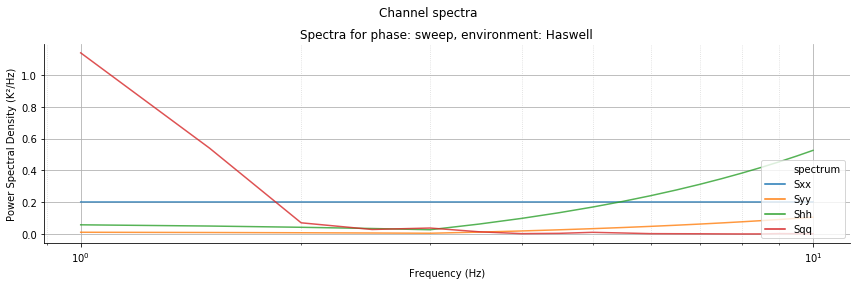

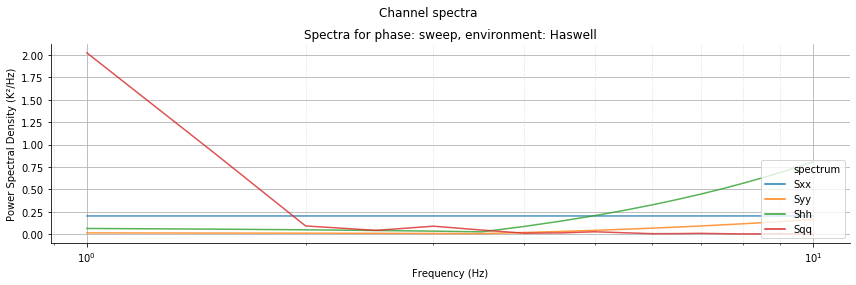

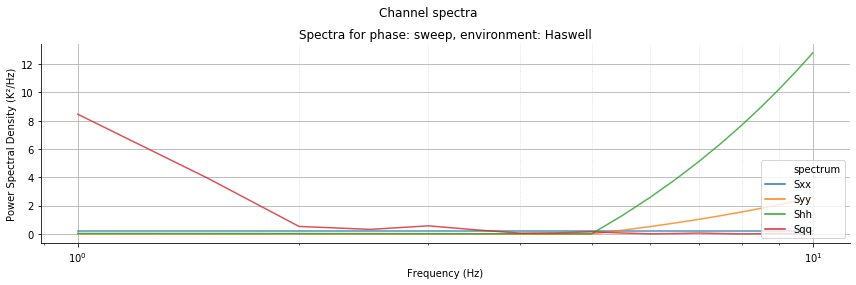

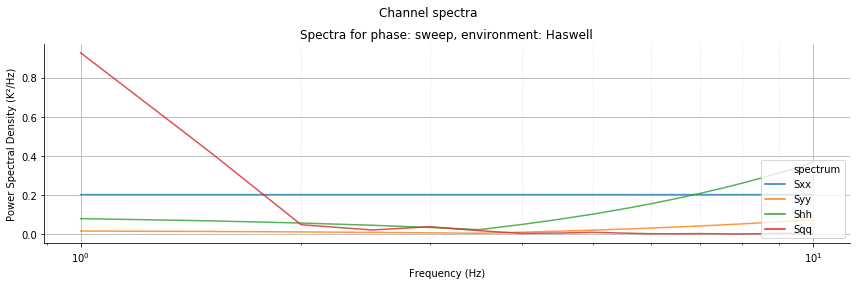

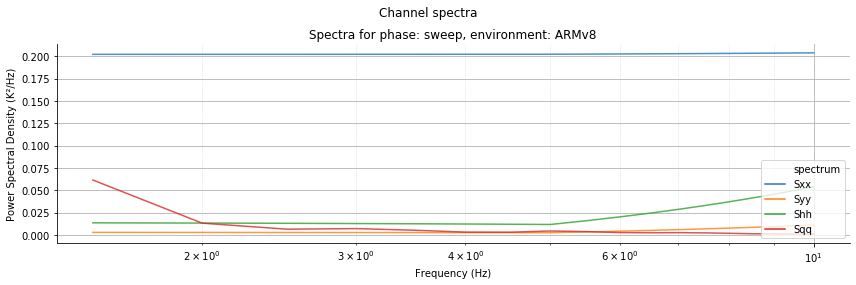

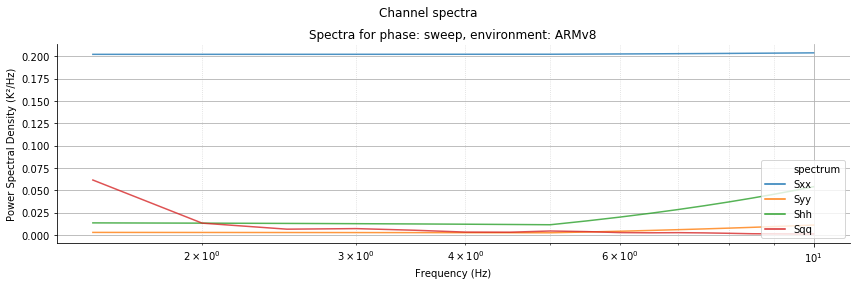

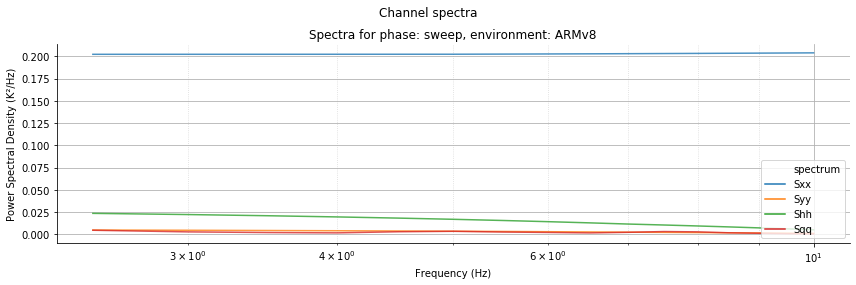

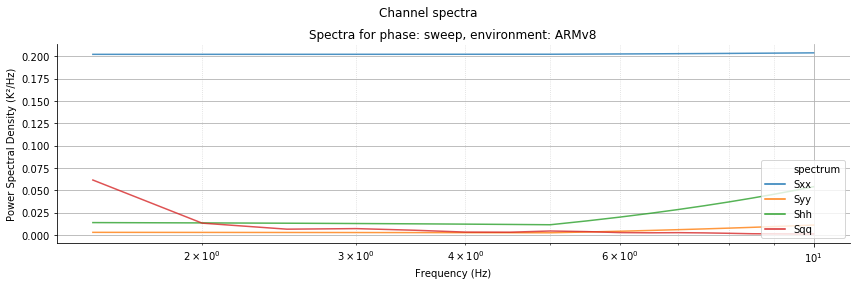

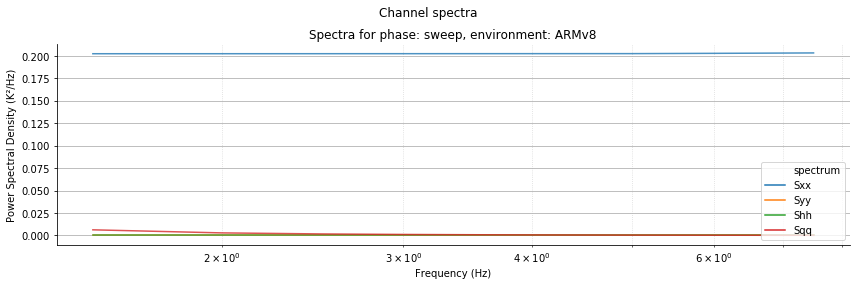

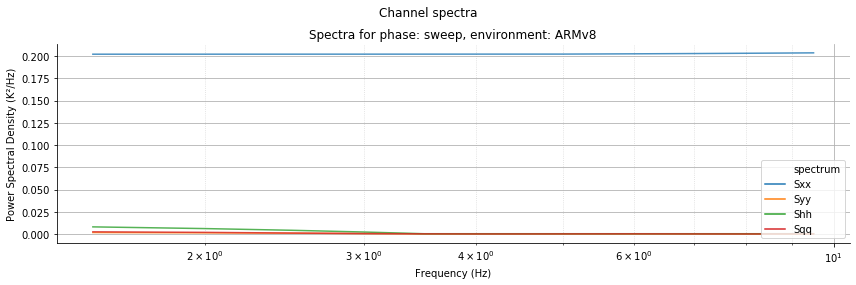

In [9]:
zones = {'Haswell': [0,2,4,6], 'ARMv8': list(range(6))}

parameters = {"host":[], "core":[], "C_wf":[], "C_cwf":[]}
phase = "sweep"
for env in ['Haswell', "ARMv8"]:
    for zone in zones[env]:
        del experiment.spectra
        experiment.generate_spectra(
            phases=[phase],
            envs=[env],
            reps=[0],
            # other keyword args below
            window_size=400 if "ARMv" in env else 2000,
            io={
                "matcher": [(exot.util.wrangle.Matcher(
                    "thermal",
                    "msr"   if (("Haswell" in env) or ("Sandy" in env)) else "sysfs",
                    ["core" if (("Haswell" in env) or ("Sandy" in env)) else "zone"],
                    [zone]), None)],
            }
        )
        Sqq = experiment.spectrum_as_matrix("Sqq", phase, env, 0)
        Shh = experiment.spectrum_as_matrix("Shh", phase, env, 0)
        Sxx = experiment.spectrum_as_matrix("Sxx", phase, env, 0)
        Syy = experiment.spectrum_as_matrix("Syy", phase, env, 0)
        p0  = wrangle.filter_data(
                experiment.p0, phase=phase, environment=env, repetition=0)['p0'].values[0]

        for _spectrum in [("Sqq",Sqq), ("Shh",Shh), ("Sxx",Sxx), ("Syy",Syy)]:
            pd.DataFrame({"frequency:fft::Hz": _spectrum[1][:,0],
                          "power_spectral_density:K²/Hz": _spectrum[1][:,1]}).to_csv(
                experiment.path.joinpath("{}_{}_core{}.dat".format(_spectrum[0],env,zone)),
                sep=",",
                encoding="utf-8",
                index=False,
            )
        
        parameters['host'].append(env)
        parameters['core'].append(zone)
        parameters['C_wf'].append(capacity.classic_waterfilling(p0, Sqq, Shh))
        parameters['C_cwf'].append(capacity.constrained_waterfilling(p0, Sqq, Shh))
        with FrequencySweepExperimentPlotter(experiment) as plotter:
            plotter.plot_channel_spectra()
        
            
        for cur_run_tuple in experiment.phases[phase].items():
            cur_run = cur_run_tuple[1]
            if (
                env == "Haswell" 
                and zone == 2
                and cur_run.config['frequency'] in [5.1,14.9,25.0,34.5]
               ):
                pd.DataFrame({"frequency:fft::Hz":cur_run.o_fspectrum.iloc[:,0],
                               "power_spectral_density:K²/Hz":cur_run.o_fspectrum.iloc[:,-1]}).to_csv(
                        experiment.path.joinpath("Sxx_%s_core%i_%03i.dat" % (
                                                     env,zone,cur_run.config['frequency']*10)),
                        sep=",",
                        encoding="utf-8",
                        index=False,
                    )
                pd.DataFrame({"frequency:fft::Hz":cur_run.i_fspectrum.iloc[:,0],
                               "power_spectral_density:K²/Hz":cur_run.i_fspectrum.iloc[:,-1]}).to_csv(
                        experiment.path.joinpath("Syy_%s_core%i_%03i.dat" % (
                                                     env,zone,cur_run.config['frequency']*10)),
                        sep=",",
                        encoding="utf-8",
                        index=False,
                    )
            cur_run.save_ingestion_data()
            cur_run.remove_ingestion_data()
parameters = pd.DataFrame(parameters)
parameters

In [10]:
assert experiment.config.experiment_exists_action == "update", "re-write only in update mode!"
experiment.write()